# EU Voters and Kommunale Elections

Non-Danish citizens can vote in a few elections here. EU citizens and foreigners who have lived in Denmark for more than four years permanently can vote in regional and local elections.

How significant is this proportion of voters?

I have no data for the long-term residents but the EU citizen data exist on Statbank.dk (FOLK1C)

So let's have a look...

In [3]:
#Importing mah libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
from matplotlib.patches import Wedge
import squarify  
import textwrap  


In [4]:
#  Local Election Data, got this from KVRES on statbank (I really love statbank, did I tell you that today?)
df_stemmer = pd.read_csv('kommunalvalg.csv',encoding='utf-8', header=None)
df_stemmer.columns=['Party','Location','Votes']
#df_stemmer.head()

In [5]:
# Pivoting the table so you can inspect per kommune
df_pivot = df_stemmer.pivot_table(index='Location', columns='Party', values='Votes', aggfunc='sum').reset_index()
# Reorder columns after pivoting
columns = ['Location', 'GYLDIGE STEMMER I ALT'] + [col for col in df_pivot.columns if col not in ['Location', 'GYLDIGE STEMMER I ALT']]
df_pivot = df_pivot[columns]
df_pivot.columns.name = None  # Remove the name of columns index
#df_pivot.head() #debugging step

In [6]:
# Figure out what party got as a percentage of the valid votes cast in the 2021 local elections

total_votes_col = 'GYLDIGE STEMMER I ALT'
party_columns = [col for col in df_pivot.columns if col not in ['Location', total_votes_col]]

# Insert a percentage column after each party column
for party in party_columns:
    percent_col = f"{party} %"
    df_pivot[percent_col] = (df_pivot[party] / df_pivot[total_votes_col] * 100).round(1)

# Rearrange columns to place the percentage column right after each party's votes
new_column_order = ['Location', total_votes_col]
for party in party_columns:
    new_column_order.extend([party, f"{party} %"])

# Reorder the DataFrame columns
df_pivot = df_pivot[new_column_order]


In [7]:
#Here is where we can keep the elections data
df_elections = df_pivot
#df_elections.head()

In [8]:
# Now let's look at the numbers of EU and Danish citizens in the kommuner
#  EU and Danish Citizens above the age of 20 (I wish I could get 18+ but I can't. Fingers crossed it is reasonably representative of what I do have)
df_voters = pd.read_csv('voters.csv',encoding='utf-8', header=None, sep=';')
df_voters.columns=['Year','Location','Danish','EU']
df_voters = df_voters.drop(columns=['Year']) #They're all from the same year

In [9]:
# Calculate the total voters (of course there are some non-EU, non-Danes long term residents who get the vote but I don't have data on them)
df_voters['Total'] = df_voters['Danish'] + df_voters['EU']

# Calculate the percentage columns and round to 1 decimal place
df_voters['Percentage Danish'] = (df_voters['Danish'] / df_voters['Total'] * 100).round(1)
df_voters['Percentage EU'] = (df_voters['EU'] / df_voters['Total'] * 100).round(1)

In [10]:
# Sort the DataFrame by the percentage of EU adults column
df_voters = df_voters.sort_values(by='Percentage Danish').reset_index(drop=True)

In [11]:
# Sort and select the top 40 kommunes by Percentage EU
top_40_kommunes = df_voters.sort_values(by='Percentage EU', ascending=False).head(90)

# Merge the top 35 kommunes with the kommunalvalg data based on the kommune name
merged_df = pd.merge(top_40_kommunes, df_elections, on='Location', how='inner')

In [12]:
# Load the GeoJSON file with kommune boundaries
gdf_kommuner = gpd.read_file('kommuner.geojson')

# Merge the GeoDataFrame with df_voters on 'komnavn' in the GeoDataFrame and 'Location' in df_voters
gdf_merged = gdf_kommuner.merge(df_voters[['Location', 'Percentage EU']], left_on='KOMNAVN', right_on='Location', how='left')


Well done for making it this far, the data is cleaned and shaped and we are ready for the good bit. 
What is the ratio of EU to Danish adults in Denmark's kommuner?

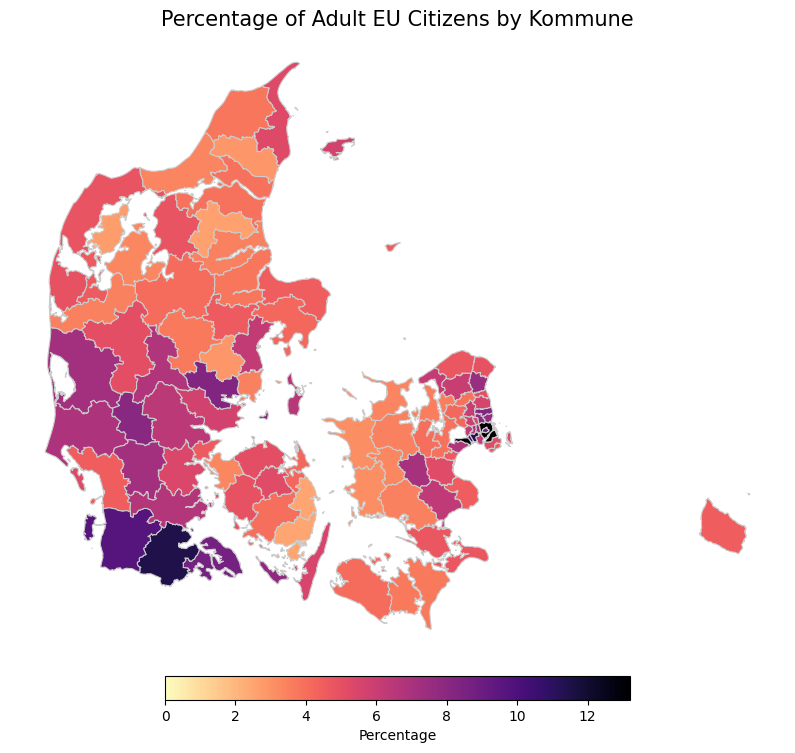

In [13]:
# Let's look at the data plotted on a map
fig, ax = plt.subplots(1, 1, figsize=(10, 12))
gdf_merged.plot(
    column='Percentage EU',
    cmap='magma_r',  # Use a colour map that enhances contrast for close values, it's also close the the CPHPost brand colour scheme
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    vmin=0,          
    #vmax=20,         
    legend_kwds={
        'label': "Percentage",
        'orientation': "horizontal",
        'shrink': 0.6,  
        'pad': 0.02,    
    }
)

# Customize the plot
ax.set_title('Percentage of Adult EU Citizens by Kommune', fontsize=15)
ax.axis('off') 

plt.show()


It's not all CPH, is it?! There are high percentages of EU citizens all over Denmark. 
Ok, so the next bit is about seeing where the voting percentage of EU citizens would place in the 2021 local election cycle.
It's obviously a flawed measure because
1) Some of these people actually voted in that election and so they are being double counted
2) It is not 2021 anymore

But we're doing it anyway and just need to breathe the anxiety away that it is not the perfect way of measuring the effect.

I will only do it for the top 90 kommuner. 

In [14]:
# List to store each kommune's ordered DataFrame
kommune_dfs = []

# Loop over each row in merged_df (each row represents a kommune)
for idx, row in merged_df.iterrows():
    kommune_name = row['Location']
    total_votes = row['GYLDIGE STEMMER I ALT']
    eu_votes = row['EU']
    eu_percentage = (eu_votes / total_votes) * 100
    
    # Create a DataFrame for the current kommune's parties and percentages
    kommune_data = pd.DataFrame({
        'Party': [col for col in merged_df.columns if ' %' in col],
        'Votes': [row[col.replace(' %', '')] for col in merged_df.columns if ' %' in col],
        'Vote Percentage': [row[col] for col in merged_df.columns if ' %' in col]
    })
    
    # Drop parties with zero votes
    kommune_data = kommune_data[kommune_data['Votes'] > 0]
    
    # Add the "EU Party" row
    eu_row = pd.DataFrame({
        'Party': ['EU Voters'],
        'Votes': [eu_votes],
        'Vote Percentage': [eu_percentage]
    })
    kommune_data = pd.concat([kommune_data, eu_row], ignore_index=True)
    
    # Sort by Vote Percentage in descending order
    kommune_data = kommune_data.sort_values(by='Vote Percentage', ascending=False).reset_index(drop=True)
    
    # Add the kommune name for context
    kommune_data['Kommune'] = kommune_name
    
    # Append to the list
    kommune_dfs.append(kommune_data)

In [15]:
#Individual kommune lookup, if you are curious
kommune_dfs[1].head(10)

,Party,Votes,Vote Percentage,Kommune
0,Enhedslisten %,75698,24.600000,København
1,EU Voters,57790,18.812461,København
2,A. Socialdemokratiet %,52874,17.200000,København
3,C. Det Konservative Folkeparti %,40172,13.100000,København
4,B. Radikale Venstre %,36688,11.900000,København
5,F. SF - Socialistisk Folkeparti %,33824,11.000000,København
6,"V. Venstre, Danmarks Liberale Parti %",23578,7.700000,København
7,Alternativet %,8988,2.900000,København
8,I. Liberal Alliance %,8428,2.700000,København
9,D. Nye Borgerlige %,6455,2.100000,København


In [16]:
# List to store kommunes where the hypothetical 'EU Party' is in the top 5
# This is the data exploration step before the cool visualisations
top_5_eu_kommunes = []

# Loop through each kommune DataFrame
for df in kommune_dfs:
    # Check if 'EU Voters' is within the top 5 rows
    if 'EU Voters' in df.iloc[:5]['Party'].values:
        kommune_name = df['Kommune'].iloc[0]  # Get the kommune name
        top_5_eu_kommunes.append(kommune_name)



In [17]:
# Count the number of kommunes with 'EU Party' in the top 5
num_top_5_eu_kommunes = len(top_5_eu_kommunes)

print(f"Number of kommunes with 'EU Party' in the top 5 by vote percentage: {num_top_5_eu_kommunes}")


Number of kommunes with 'EU Party' in the top 5 by vote percentage: 63


In [18]:
import locale

# Collect kommuner by the rank of "EU Voters" (1-based rank after your sort)
ranks_to_collect = [2, 3, 4, 5]
kommune_names_by_rank = {r: [] for r in ranks_to_collect}

for df in kommune_dfs:
    # find the "EU Voters" row (case-insensitive), then compute 1-based rank
    idxs = df.index[df["Party"].astype(str).str.casefold() == "eu voters"]
    if len(idxs):
        rank = int(idxs[0]) + 1
        if rank in kommune_names_by_rank:
            kommune_names_by_rank[rank].append(str(df["Kommune"].iloc[0]))

# Try Danish collation; fall back to case-insensitive ASCII if locale isn't available
try:
    locale.setlocale(locale.LC_COLLATE, "da_DK.UTF-8")
    dk_key = locale.strxfrm
except locale.Error:
    dk_key = lambda s: s.casefold()

# Print nicely
for rank in sorted(kommune_names_by_rank):
    names = sorted(kommune_names_by_rank[rank], key=dk_key)
    print(f"\nRank {rank} (n={len(names)}):")
    for name in names:
        print(f" - {name}")



Rank 2 (n=3):
 - Brøndby
 - Ishøj
 - København

Rank 3 (n=12):
 - Aabenraa
 - Ballerup
 - Billund
 - Faxe
 - Frederikshavn
 - Gentofte
 - Herning
 - Høje-Taastrup
 - Horsens
 - Lolland
 - Sønderborg
 - Vallensbæk

Rank 4 (n=29):
 - Ærø
 - Assens
 - Dragør
 - Favrskov
 - Frederiksberg
 - Glostrup
 - Greve
 - Haderslev
 - Halsnæs
 - Hedensted
 - Hjørring
 - Holbæk
 - Hørsholm
 - Hvidovre
 - Ikast-Brande
 - Jammerbugt
 - Lyngby-Taarbæk
 - Mariagerfjord
 - Nordfyns
 - Randers
 - Ringsted
 - Rødovre
 - Struer
 - Thisted
 - Tønder
 - Varde
 - Vejen
 - Vejle
 - Viborg

Rank 5 (n=19):
 - Egedal
 - Esbjerg
 - Fredensborg
 - Furesø
 - Gribskov
 - Guldborgsund
 - Helsingør
 - Herlev
 - Hillerød
 - Kerteminde
 - Køge
 - Langeland
 - Læsø
 - Lemvig
 - Rudersdal
 - Samsø
 - Skive
 - Solrød
 - Vesthimmerlands
